# Preprocessing and Linear Regression

## Preprocessing

### Importing libraries and datasets

In [43]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import functions as cf
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



In [44]:
combined_file_path = '../data/cleaned/winequality_combined_cleaned.csv' 
red_file_path = '../data/cleaned/winequality_red_cleaned.csv'
white_file_path = '../data/cleaned/winequality_white_cleaned.csv'
combined_df = pd.read_csv(combined_file_path)
red_df = pd.read_csv(red_file_path, index_col=0)
white_df = pd.read_csv(white_file_path, index_col=0)

In [45]:
def linear_regression(X_train, X_test, y_train, y_test):
    # Linear regression
    lm = LinearRegression()
    model = lm.fit(X_train, y_train)
    print(f'model coefficients:\n {model.coef_}\n')
    print(f'model intercept:\n {model.intercept_}\n')
    
    # Applying model to X test
    y_pred = model.predict(X_test)
    
    # Ensure y_test is in the correct format (pandas Series or 1D numpy array)
    if isinstance(y_test, pd.Series):
        y_test_reset = y_test.reset_index(drop=True)
    else:
        y_test_reset = y_test  # Assuming y_test is already a numpy array
    
    # Creating combined table with y_test and y_pred
    # Check if y_test_reset is a pandas Series and convert y_pred to a similar type
    if isinstance(y_test_reset, pd.Series):
        y_pred_series = pd.Series(y_pred, index=y_test_reset.index, name='y_pred')
        residuals_df = pd.concat([y_test_reset, y_pred_series], axis=1)
    else:
        # If inputs are numpy arrays, stack them horizontally
        residuals_df = np.column_stack((y_test_reset, y_pred))
        # Convert to DataFrame for easier manipulation later on
        residuals_df = pd.DataFrame(residuals_df, columns=["y_test", "y_pred"])
    
    # Calculating residuals
    residuals_df["residual"] = residuals_df["y_test"] - residuals_df["y_pred"]
    print(f'Residuals:\n {residuals_df}\n')

    # Root mean squared error
    rmse = mse(y_test_reset, residuals_df["y_pred"], squared=False)
    print(f'Root mean squared error: {rmse} \n')

    # R^2
    r2 = r2_score(y_test_reset, residuals_df["y_pred"])
    print(f'R2: {r2} \n')

    # Calculating adjusted R^2
    n = X_train.shape[0]  # Number of observations in the training set
    p = X_train.shape[1]  # Number of features used for training
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print(f'Adjusted R2: {adjusted_r2} \n')

    return model.coef_






def evaluate_model_performance(y_test, y_pred, X_train):
    """
    Evaluates the performance of a regression model by calculating and printing
    the ME, MAE, MSE, RMSE, R^2, and adjusted R^2.

    Parameters:
    - y_test: pandas Series or DataFrame, actual target values.
    - y_pred: array-like or pandas Series, predicted target values.
    - X_train: pandas DataFrame, feature set used for training the model.

    Returns:
    - Prints the ME, MAE, MSE, RMSE, R^2, and adjusted R^2 of the model.
    """
    # Ensure y_pred is a DataFrame with appropriate column name
    if not isinstance(y_pred, pd.DataFrame):
        y_pred = pd.DataFrame(y_pred, columns=["y_pred"])
    else:
        y_pred = y_pred.rename(columns={y_pred.columns[0]: "y_pred"})

    # Reset index and rename y_test for consistency
    if isinstance(y_test, pd.Series):
        y_test = y_test.reset_index(drop=True).rename("y_test")
    elif isinstance(y_test, pd.DataFrame):
        y_test = y_test.reset_index(drop=True)
        y_test.columns = ["y_test"]

    # Concatenate actual and predicted values and calculate residuals
    residuals_df = pd.concat([y_test, y_pred], axis=1)
    residuals_df["residual"] = residuals_df["y_test"] - residuals_df["y_pred"]

    # Calculate Mean Error (ME)
    me = residuals_df["residual"].mean()
    print(f'Mean Error (ME): {me:.4f}')

    # Calculate Mean Absolute Error (MAE)
    mae_value = mae(residuals_df["y_test"], residuals_df["y_pred"])
    print(f'Mean Absolute Error (MAE): {mae_value:.4f}')

    # Calculate Mean Squared Error (MSE)
    mse_value = mse(residuals_df["y_test"], residuals_df["y_pred"])
    print(f'Mean Squared Error (MSE): {mse_value:.4f}')

    # Calculate Root Mean Squared Error (RMSE)
    rmse = mse(residuals_df["y_test"], residuals_df["y_pred"], squared=False)
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

    # Calculate R^2
    r2 = r2_score(residuals_df["y_test"], residuals_df["y_pred"])
    print(f'R²: {r2:.4f}')

    # Calculate Adjusted R^2
    n = X_train.shape[0]  # Number of observations
    p = X_train.shape[1]  # Number of features
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print(f'Adjusted R²: {adjusted_r2:.4f}')


def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit,5)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit,5)
    

    # Function to handle outliers
def handle_outliers(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit, 5)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit, 5)
    return dataframe

# Apply outlier handling to specific columns
def apply_outlier_thresholds(dataframe):
    # Update this list to include only the columns that need outlier treatment
    columns_to_treat = ['citric_acid', 'chlorides', 'total_sulfur_dioxide', 'pH', 'sulphates']
    for col in columns_to_treat:
        dataframe = handle_outliers(dataframe, col)
    return dataframe



## Correlations

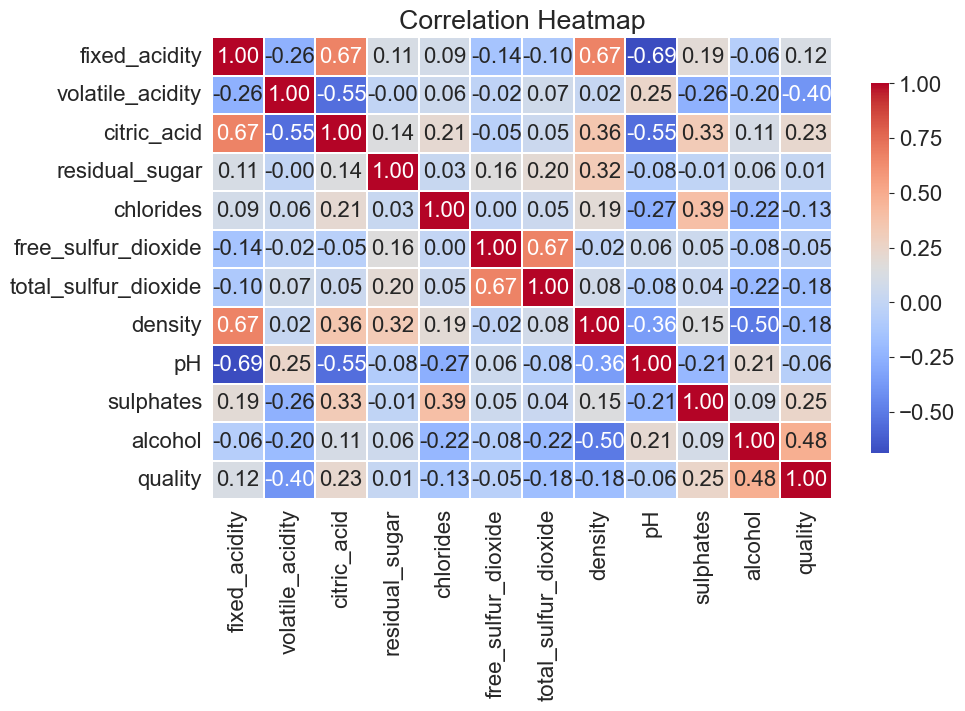

In [39]:
#Red_wine
corr_matrix_red = red_df.corr()
plt.figure(figsize=(10, 6)) 
sns.heatmap(corr_matrix_red, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.05, cbar_kws={'shrink': .8})
plt.title('Correlation Heatmap')  
plt.show()


## IQR Method to handle Outliers

In [41]:
columns_gpt = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'sulphates']# only columns identified as having outliers

columns_matthew = ['citric_acid', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'pH', 'sulphates']

columns_combined = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'pH', 'sulphates']

columns_all = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol']

## Distributions

<Figure size 1500x1500 with 0 Axes>

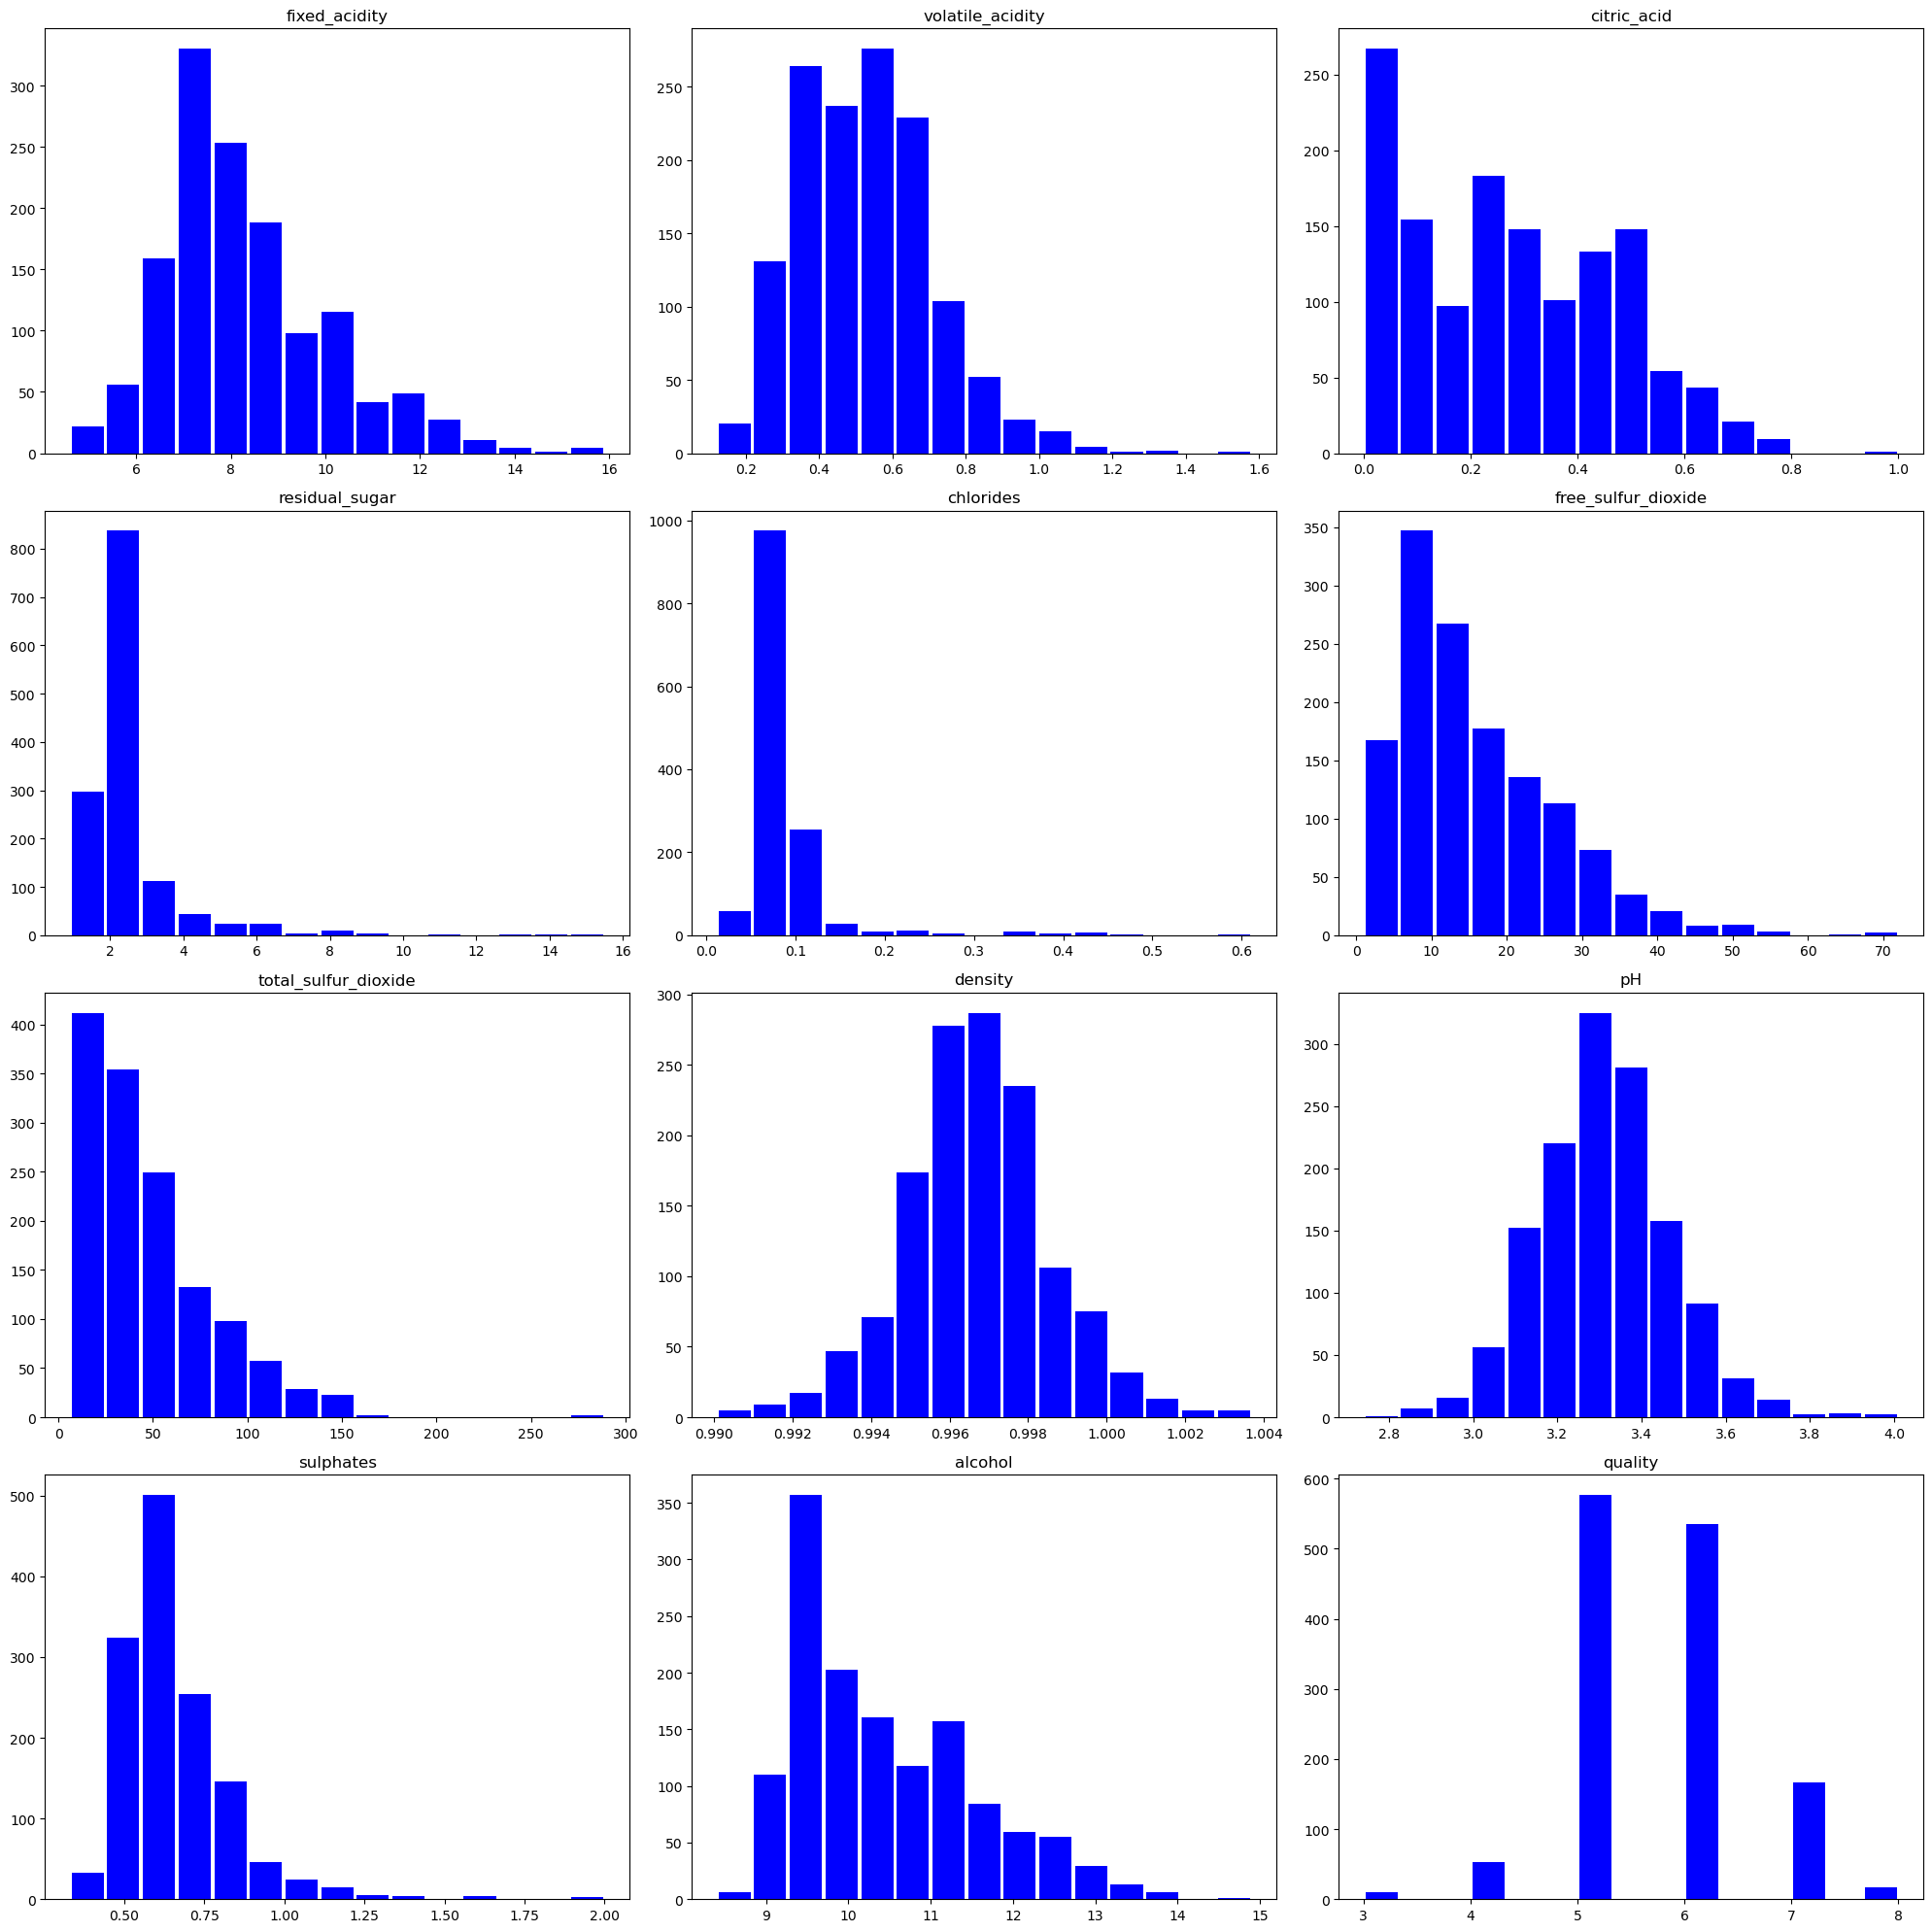

In [8]:
plt.figure(figsize=(15, 15))
red_df.hist(bins=15, grid=False, figsize=(20, 20), color='blue', zorder=2, rwidth=0.9)
plt.tight_layout()
plt.rcParams.update({'font.size': 16})
plt.show()

### Splitting data into X and y

#### Red Wine

In [9]:
X = red_df.drop(['quality', 'free_sulfur_dioxide'], axis=1)
#X = pd.DataFrame(red_df[['citric_acid', 'total_sulfur_dioxide', 'density', 'pH', 'residual_sugar', 'chlorides', 'sulphates', 'alcohol']])
y = pd.DataFrame(red_df["quality"])

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

## Applying Scalers and Transforms

### PowerTransformer on X

In [12]:
pt = PowerTransformer(method='yeo-johnson')
pt.fit(X_train)
X_train_p = pd.DataFrame(pt.transform(X_train))
X_test_p= pd.DataFrame(pt.transform(X_test))

### PowerTransformer on y

In [13]:
pt_y = PowerTransformer(method='yeo-johnson')
pt_y.fit(y_train)
y_train_p = pt_y.transform(y_train)
y_test_p = pt_y.transform(y_test)

### MinMax Scaler on X

In [14]:
scaler_mm_x = MinMaxScaler()
scaler_mm_x.fit(X_train)
X_train_mm = scaler_mm_x.transform(X_train)
X_test_mm = scaler_mm_x.transform(X_test)

### MinMax Scaler on y

In [17]:
scaler_mm_y = MinMaxScaler()
scaler_mm_y.fit(y_train)
y_train_mm = scaler_mm_y.transform(y_train)
y_test_mm = scaler_mm_y.transform(y_test)

### Standard Scaler on X

In [18]:
scaler_s_x = StandardScaler()
scaler_s_x.fit(X_train)
X_train_s = scaler_s_x.transform(X_train)
X_test_s = scaler_s_x.transform(X_test)

### Standard Scaler on y

In [19]:
scaler_s_y = StandardScaler()
scaler_s_y.fit(y_train)
y_train_s = scaler_s_y.transform(y_train)
y_test_s = scaler_s_y.transform(y_test)

## Linear Regression Model 

In [20]:
# Linear regression
lm = LinearRegression()
model = lm.fit(X_train_s, y_train)
print(f'model coefficients:\n {model.coef_}\n')
print(f'model intercept:\n {model.intercept_}\n')

# Applying model to X test
y_pred = model.predict(X_test_s)
#y_pred = pd.DataFrame(scaler_s_y.inverse_transform(y_pred)) # inversing y
y_pred = pd.DataFrame(y_pred)

y_pred = y_pred.rename(columns = {0:"y_pred"})

y_test = y_test.reset_index(drop=True)
y_test = y_test.rename(columns = {"quality":"y_test"})

residuals_df = pd.concat([y_test,y_pred], axis = 1)
residuals_df["residual"] = residuals_df["y_test"] - residuals_df["y_pred"]


# Root mean squared error
rmse = mse(y_test, residuals_df["y_pred"], squared=False)
print(f'Root mean squared error: {rmse} \n')

# R^2
r2 = r2_score(y_test, residuals_df["y_pred"])
print(f'R2: {r2} \n')

# Calculating adjusted R^2
n = X_train.shape[0]  # Number of observations in the training set
p = X_train.shape[1]  # Number of features used for training
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R2: {adjusted_r2} \n')

residuals_df

model coefficients:
 [[-0.05870044 -0.18682068 -0.01634331  0.00159107 -0.09999062 -0.09058569
   0.03483982 -0.12019193  0.15683492  0.32752532]]

model intercept:
 [5.63199215]

Root mean squared error: 0.6346665408291888 

R2: 0.4040282724352816 

Adjusted R2: 0.39811585450309195 



,y_test,y_pred,residual
0,5,5.185203,-0.185203
1,6,5.767942,0.232058
2,7,6.371127,0.628873
3,5,5.171216,-0.171216
4,4,5.139013,-1.139013
...,...,...,...
335,5,5.373062,-0.373062
336,6,5.878668,0.121332
337,6,5.631215,0.368785
338,7,6.519930,0.480070


In [21]:
#Mean error
residuals_df["residual"].mean()

-0.029997048207661196

In [22]:
#Mean square error
ms_error = mse(y_test,residuals_df["y_pred"])
ms_error

0.4028016180480884

In [23]:
#Mean absolute error
ma_error = mae(y_test,residuals_df["y_pred"])
ma_error

0.48802255035876846

## Check for overfitting/underfitting

In [24]:
# Computing R2_score for train_set
y_pred_train = pd.DataFrame(model.predict(X_train_s))

r2_train = r2_score(y_train,y_pred_train)
print(f'R2: {r2_train} \n')

# Calculating adjusted R^2
n = X_train.shape[0]  # Number of observations in the training set
p = X_train.shape[1]  # Number of features used for training
adjusted_r2_train = 1 - (1 - r2_train) * (n - 1) / (n - p - 1)
print(f'Adjusted R2: {adjusted_r2_train} \n')

R2: 0.3448217139861268 

Adjusted R2: 0.3383219294026558 



## Feature Importance

In [25]:
#getting feature names and coefficients
feature_names = list(X_train.columns)
coefficients = model.coef_
coefficients = [i for i in coefficients[0]]

#creating feature importance dataframe
fi_dict = {"name":feature_names,"coeff":coefficients}
fi_df = pd.DataFrame(fi_dict)
fi_df = fi_df.sort_values('coeff', ascending=False)

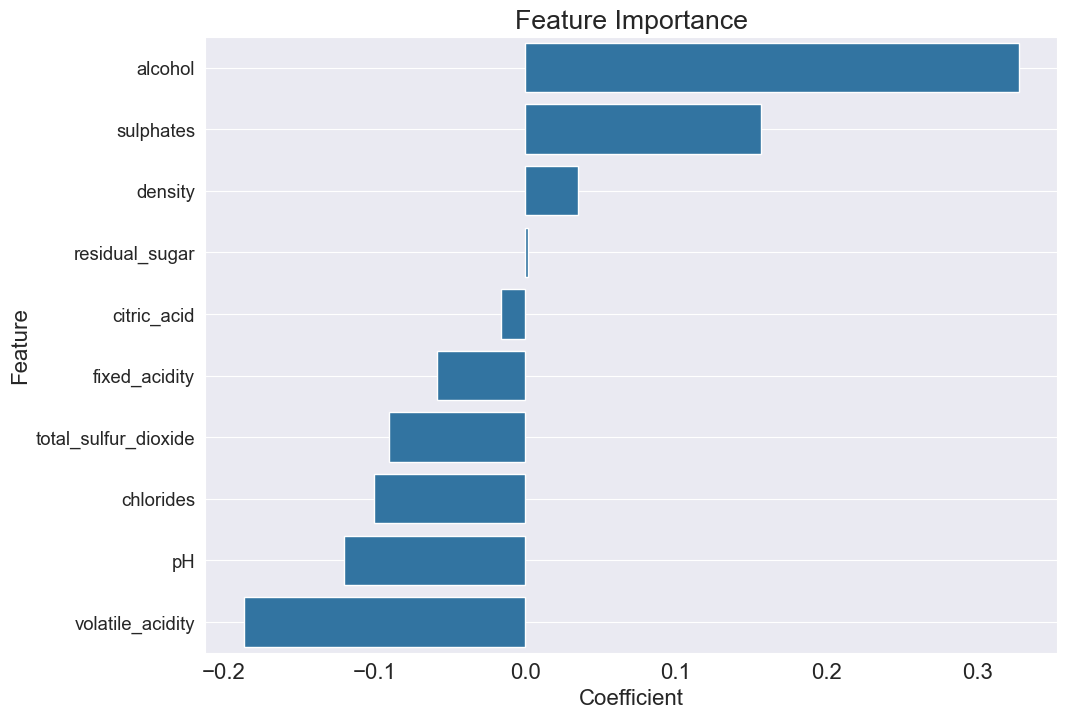

In [26]:
#Feature importance plot for standardized data
plt.figure(figsize=(11, 8))
sns.set_style("darkgrid")
sns.barplot(y="name", x="coeff", data=fi_df)
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.grid()
plt.xticks()
plt.yticks(fontsize='small')
plt.show()

## Experiments 

## Recursive Feature Elimination (RFE)

In [27]:
from sklearn.feature_selection import RFECV

# Create a new instance of RFECV with the linear regression estimator
rfecv = RFECV(estimator=LinearRegression(), step=1, cv=5, scoring='neg_mean_squared_error')

# Fit RFECV to the scaled training data
rfecv.fit(X_train_p, y_train)

# Transform the training and testing sets using the selected features
X_train_selected = rfecv.transform(X_train_p)
X_test_selected = rfecv.transform(X_test_p)

# Train a new model on the selected features
model_selected = LinearRegression()
model_selected.fit(X_train_selected, y_train)

# Predict the quality on the testing set with selected features
y_pred_selected = model_selected.predict(X_test_selected)

# Calculate the performance metrics for the model with selected features
mse_selected = mse(y_test, y_pred_selected)

# Number of features selected
n_features_selected = rfecv.n_features_

# Root mean squared error
rmse_selected = mse(y_test, y_pred_selected, squared=False)
print(f'Root mean squared error: {rmse} \n')

r2_selected = r2_score(y_test, y_pred_selected)
print(f'R2: {r2_selected} \n')

# Calculating adjusted R^2
n_sel = X_train.shape[0]  # Number of observations in the training set
p_sel = n_features_selected  # Number of features used for training
adjusted_r2_selected = 1 - (1 - r2_selected) * (n_sel - 1) / (n_sel - p_sel - 1)
print(f'Adjusted R2: {adjusted_r2_selected} \n')

mse_selected, r2_selected, n_features_selected

Root mean squared error: 0.6346665408291888 

R2: 0.3913136292135616 

Adjusted R2: 0.3870991835206782 



(0.41139511103732884, 0.3913136292135616, 7)

##### Note: 
After applying RFE we did not see any significant improvement in our model metrics so it was not included in the final preprocessing pipeline

### Pipeline

#### Defining pipeline

In [32]:
# List of features used in your model
selected_features = [
    'fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
    'chlorides', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol'
]

# Create a FunctionTransformer to integrate the outlier function into the pipeline
outlier_transformer = FunctionTransformer(apply_outlier_thresholds)

# Define the ColumnTransformer to apply scaling only to the selected features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), selected_features)  # Apply standard scaling to selected features
    ],
    remainder='drop'  # Drop other columns that are not listed in selected_features
)

# Create the preprocessing pipeline with outlier handling and scaling
preprocessing_pipeline = Pipeline(steps=[
    ('outliers', outlier_transformer),  # First step is to apply the outlier_transformer
    ('preprocessor', preprocessor),      # Next, apply the preprocessor defined above
])


### Applying pipeline to red_wine to validate the pipeline functions correctly

In [33]:
# Now apply the pipeline to the DataFrame
# Here we assume red_df is already loaded and contains the column 'quality'
X_red = red_df.drop(['quality'], axis=1)  # Drop the target variable to isolate features
y_red = red_df['quality']                 # Isolate the target variable

# Define the columns we want to keep and preprocess
selected_features = [
    'fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
    'chlorides', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol'
]

# Apply the pipeline to the features
red_processed = preprocessing_pipeline.fit_transform(X_red)

# Convert the processed features into a DataFrame
# Note: We need to be careful here because pipeline transformations can return a NumPy array
red_processed_df = pd.DataFrame(red_processed, columns=selected_features)

X_train, X_test, y_train, y_test = train_test_split(red_processed_df, y, random_state=42)

y_red_pred = model.predict(X_test)
type(y_red_pred)
type(y_test)

/Users/jameskenny/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


pandas.core.frame.DataFrame

In [34]:
evaluate_model_performance(y_test, y_red_pred, X_train)

Mean Error (ME): -0.0336
Mean Absolute Error (MAE): 0.4861
Mean Squared Error (MSE): 0.3988
Root Mean Squared Error (RMSE): 0.6315
R²: 0.4100
Adjusted R²: 0.4042


## Testing red wine model on white wine data

In [46]:
# Now apply the pipeline to the DataFrame
# Here we assume red_df is already loaded and contains the column 'quality'
X_white = white_df.drop(['quality'], axis=1)  # Drop the target variable to isolate features
y_white = white_df['quality']                 # Isolate the target variable

# Define the columns we want to keep and preprocess
selected_features = [
    'fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
    'chlorides', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol'
]

# Apply the pipeline to the features
X_processed_white = preprocessing_pipeline.fit_transform(X_white)

# Convert the processed features into a DataFrame
# Note: We need to be careful here because pipeline transformations can return a NumPy array
X_processed_df = pd.DataFrame(X_processed_white, columns=selected_features)

y_white_pred = model.predict(X_processed_df)

/Users/jameskenny/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [ ]:
# Example usage:
# Assume y_test, y_pred, and X_train are already defined
evaluate_model_performance(y_white, y_white_pred, X_processed_white)


### Saving model and preprocessing pipeline

### CSV export